MSFT Columns: MultiIndex([( 'Close', 'MSFT'),
            (  'High', 'MSFT'),
            (   'Low', 'MSFT'),
            (  'Open', 'MSFT'),
            ('Volume', 'MSFT')],
           names=['Price', 'Ticker'])
AAPL Columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
                  MSFT       AAPL
Date                             
2020-01-02  153.630692  72.716072
2020-01-03  151.717728  72.009125
2020-01-06  152.109879  72.582909
2020-01-07  150.722992  72.241562
2020-01-08  153.123764  73.403641


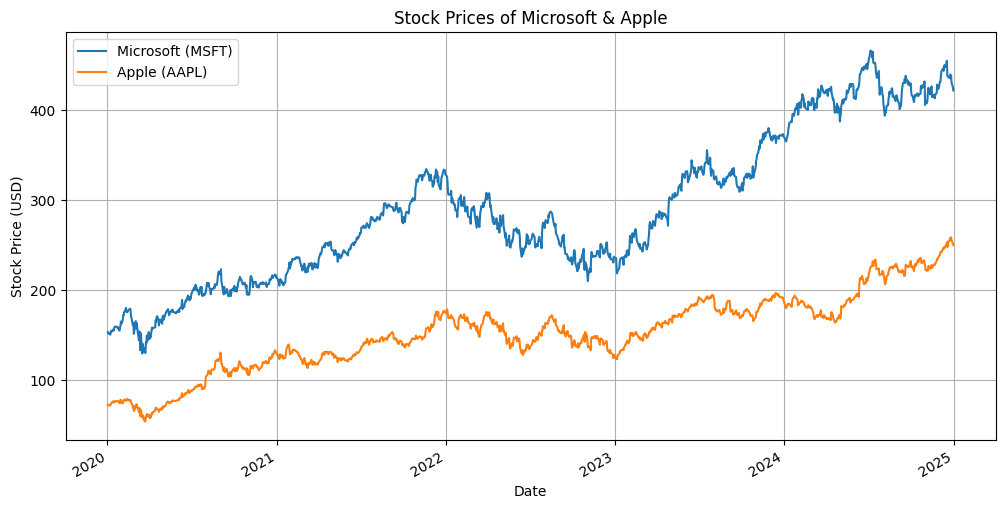

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define stock tickers
stock1 = "MSFT"
stock2 = "AAPL"

# Define date range
start_date = "2020-01-01"
end_date = "2025-01-01"

# Fetch stock data from Yahoo Finance
df1 = yf.download(stock1, start=start_date, end=end_date, progress=False)
df2 = yf.download(stock2, start=start_date, end=end_date, progress=False)

# Print column names to check for "Adj Close"
print("MSFT Columns:", df1.columns)
print("AAPL Columns:", df2.columns)

# Create a new DataFrame with Adjusted Close prices
df = pd.DataFrame()
df["MSFT"] = df1.get("Adj Close", df1.get("Close"))  # Use "Close" if "Adj Close" is missing
df["AAPL"] = df2.get("Adj Close", df2.get("Close"))

# Print first few rows to confirm data
print(df.head())

# Plot stock prices
df.plot(figsize=(12, 6), title="Stock Prices of Microsoft & Apple")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.legend(["Microsoft (MSFT)", "Apple (AAPL)"])
plt.grid()
plt.show()





                MSFT      AAPL
Date                          
2020-01-03 -0.012452 -0.009722
2020-01-06  0.002585  0.007968
2020-01-07 -0.009118 -0.004703
2020-01-08  0.015928  0.016086
2020-01-09  0.012493  0.021241


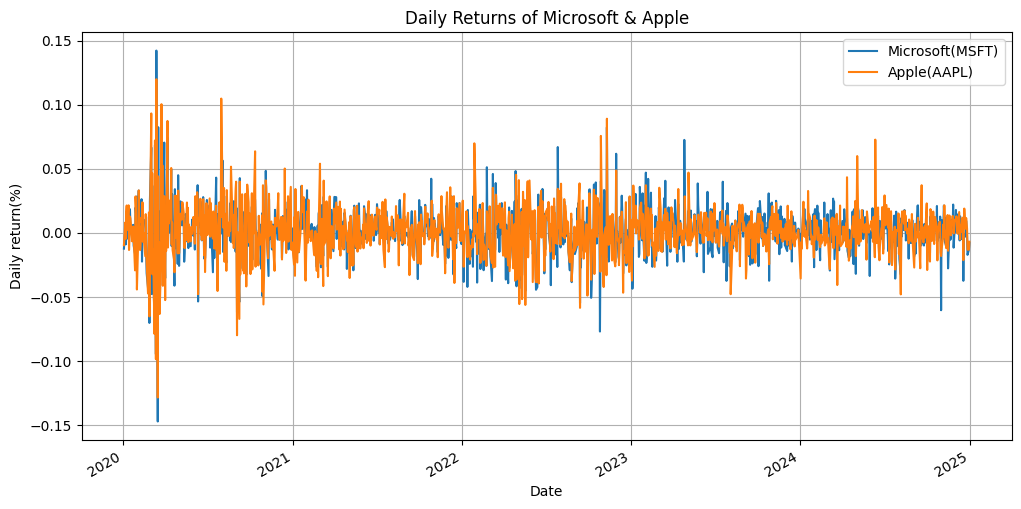

In [6]:
df_returns = df.pct_change().dropna()

print(df_returns.head())

df_returns.plot(figsize=(12,6),title = "Daily Returns of Microsoft & Apple")
plt.xlabel("Date")
plt.ylabel("Daily return(%)")
plt.legend(["Microsoft(MSFT)","Apple(AAPL)"])
plt.grid()
plt.show()

In [11]:
correlation = df_returns.head

print("Correlation Matrix:")
print(correlation)


Correlation Matrix:
<bound method NDFrame.head of                 MSFT      AAPL
Date                          
2020-01-03 -0.012452 -0.009722
2020-01-06  0.002585  0.007968
2020-01-07 -0.009118 -0.004703
2020-01-08  0.015928  0.016086
2020-01-09  0.012493  0.021241
...              ...       ...
2024-12-24  0.009374  0.011478
2024-12-26 -0.002777  0.003176
2024-12-27 -0.017302 -0.013242
2024-12-30 -0.013240 -0.013263
2024-12-31 -0.007838 -0.007058

[1257 rows x 2 columns]>


In [12]:
X = df["AAPL"]
Y = df["MSFT"]

X =sm.add_constant(X)
model = sm.OLS(Y,X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     8063.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:37:23   Log-Likelihood:                -6067.9
No. Observations:                1258   AIC:                         1.214e+04
Df Residuals:                    1256   BIC:                         1.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1627      3.188      4.128      0.0

C:\Users\vvais\AppData\Local\Temp\ipykernel_7664\1117535111.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["Spread"]=df["MSFT"]-model.params[1]*df["AAPL"]


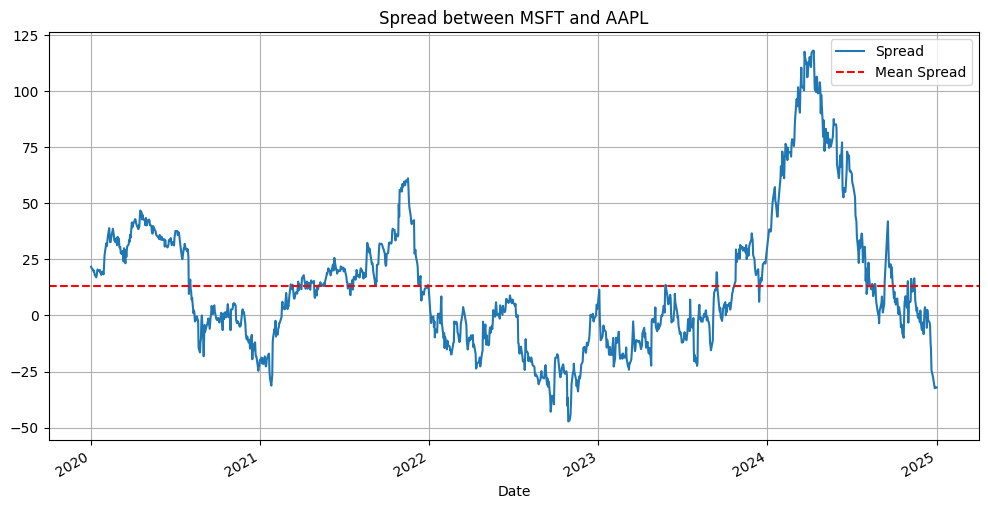

In [13]:
df["Spread"]=df["MSFT"]-model.params[1]*df["AAPL"]
df["Spread"].plot(figsize=(12,6),title="Spread between MSFT and AAPL")
plt.axhline(df["Spread"].mean(),color='red',linestyle='--',label="Mean Spread")
plt.legend()
plt.grid()
plt.show()

In [14]:
df["Z-score"]=(df["Spread"]-df["Spread"].mean())/df["Spread"].std()

df["Long"]= df["Z-score"]<-1
df["Short"]=df["Z-score"]>1

print(df[["Spread","Z-score","Long","Short"]].head())

               Spread   Z-score   Long  Short
Date                                         
2020-01-02  21.771185  0.285893  False  False
2020-01-03  21.140162  0.264937  False  False
2020-01-06  20.491843  0.243406  False  False
2020-01-07  19.723937  0.217903  False  False
2020-01-08  20.017456  0.227651  False  False


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df["Spread_Lag1"]= df["Spread"].shift(1)
df["Spread_Lag2"]= df["Spread"].shift(2)

df.dropna(inplace = True)

X =df[["Spread_Lag1","Spread_Lag2"]]
y = df["Long"].astype(int)

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"Model Accuracy:{accuracy*100:.2f}%")

Model Accuracy:96.43%


Sharpe Ratio:-0.67


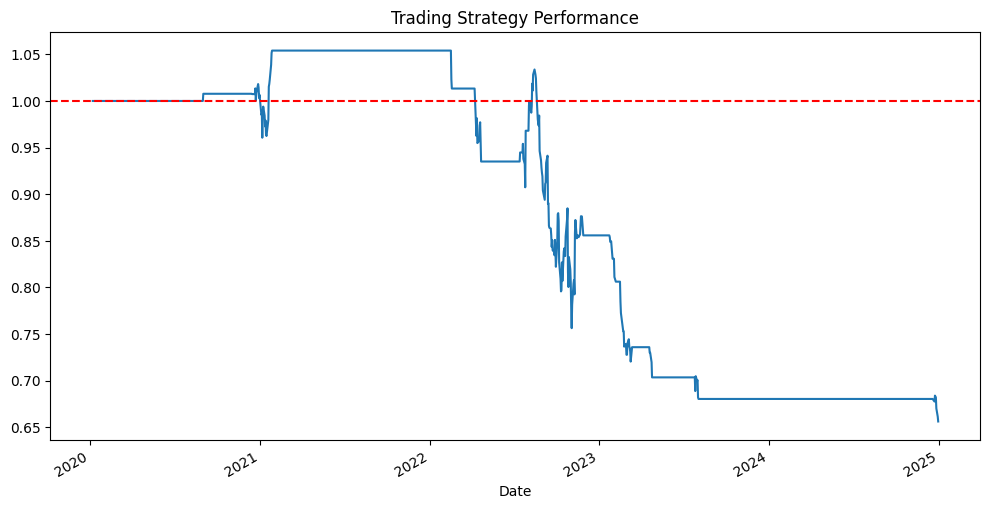

In [24]:
df["Strategy_Returns"] = df["Long"].astype(int) * df["MSFT"].pct_change()
df["Cumulative_Returns"] = (1 + df["Strategy_Returns"]).cumprod()

sharpe_ratio = df["Strategy_Returns"].mean()/df["Strategy_Returns"].std()*np.sqrt(252)
print(f"Sharpe Ratio:{sharpe_ratio:.2f}")

df["Cumulative_Returns"].plot(figsize=(12,6),title="Trading Strategy Performance")
plt.axhline(1, color="red",linestyle="--")
plt.show()

In [ ]:
import alpaca_trade_api as tradeapi


API_KEY = "your_api_key"
API_SECRET = "your_api_secret"
BASE_URL = "https://paper-api.alpaca.markets"


api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version="v2")


def place_order(symbol, qty, side):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type="market",
        time_in_force="gtc"
    )
    print(f"Order Placed: {side} {qty} {symbol}")


for index, row in df.iterrows():
    if row["Long"]:  # Buy MSFT, Sell AAPL
        place_order("MSFT", 10, "buy")
        place_order("AAPL", 10, "sell")

    elif row["Short"]:  # Sell MSFT, Buy AAPL
        place_order("MSFT", 10, "sell")
        place_order("AAPL", 10, "buy")


In [ ]:
import alpaca_trade_api as tradeapi


API_KEY = "your_api_key"
API_SECRET = "your_api_secret"
BASE_URL = "https://paper-api.alpaca.markets"


api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version="v2")


def place_order(symbol, qty, side):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type="market",p
        time_in_force="gtc"
    )
    print(f"Order Placed: {side} {qty} {symbol}")


for index, row in df.iterrows():
    if row["Long"]:  # Buy MSFT, Sell AAPL
        place_order("MSFT", 10, "buy")
        place_order("AAPL", 10, "sell")

    elif row["Short"]:  # Sell MSFT, Buy AAPL
        place_order("MSFT", 10, "sell")
        place_order("AAPL", 10, "buy")


In [ ]:
import alpaca_trade_api as tradeapi


API_KEY = "your_api_key"
API_SECRET = "your_api_secret"
BASE_URL = "https://paper-api.alpaca.markets"


api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version="v2")


def place_order(symbol, qty, side):
    api.submit_order(
        symbol=symbol,
        qty=qty,
        side=side,
        type="market",
        time_in_force="gtc"
    )
    print(f"Order Placed: {side} {qty} {symbol}")


for index, row in df.iterrows():
    if row["Long"]:  # Buy MSFT, Sell AAPL
        place_order("MSFT", 10, "buy")
        place_order("AAPL", 10, "sell")

    elif row["Short"]:  # Sell MSFT, Buy AAPL
        place_order("MSFT", 10, "sell")
        place_order("AAPL", 10, "buy")
